# Homocide Reports Data In The US
<h4>Khanh Nguyen, Marc Hipona</h4>
<h2>Overview</h2>
<p>Homocides happen everyday in our lives. It is important to be aware of increasing crime rate in the US in order to implement safety measurements. From that, this tutorial introduces a deep analysis on homocide reports in the US from 1980 to 2014. The tutorial includes four main parts. The first part will include data collecting and data cleaning processes. The second part will demonstrate how to analyze the given data and display visualization. The third part will come up with machine learning to process the analysis. Lastly, the fourth part will verify the hypotheses implied from previous part.</p>
<h2>Required Tools</h2>
<p>We recommend using Jupyter Notebook since Python is included and it is a great editor for data analysis. You will also need to following libraries:</p>
<ul>
<li>pandas</li>
<li>numpy</li>
<li>scikit-learn</li>
<li>matplotlib</li>
<li>folium</li>
</ul>
<p>For the dataset, the homocide reports data can be retrived at https://www.kaggle.com/murderaccountability/homicide-reports/data</p>

<h2>Part 1: Data Preparation</h2>
<p>The first thing we need to do is download the dataset at https://www.kaggle.com/murderaccountability/homicide-reports/data. The file downloaded will be in form of a CSV (comma-separated value) called database.csv. Then, we have to load the file to our Jupyter Notebook in order to process the data within it. To do this, pandas libraries will help us initialize the data in nice frames and columns. If you are unfamiliar with pandas, its documentation can be found at:</p>
<ul>
<li>Complete Documentation: https://pandas.pydata.org/pandas-docs/stable/</li>
<li>Pandas Cheat Sheet: https://www.datacamp.com/community/blog/python-pandas-cheat-sheet</li>
</ul>

In [45]:
#Import needed libraries
!pip install folium
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
import sklearn.metrics
import warnings
warnings.filterwarnings('ignore')

In [46]:
#Load the csv file and make dataframe
data = pd.read_csv("database.csv", dtype=object)
#Display the first 5 rows of the table
data.head()

,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,...,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
0,000001,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,...,Unknown,Male,15,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI
1,000002,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
2,000003,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,0,FBI
3,000004,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
4,000005,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,1,FBI


<h3>1.1 Data Overview</h3>
<p>The data contains some crucial information for us to analyze such as the time, locations, crime types, weapons, victim, and perpentrator info.</p> 
<h3>1.2 Data Tidying</h3>
<p>When we look at the data table, there are several columns that seem to be unnecessary to our analysis such as the Agency Code, Agency Name, Record Source, etc. In this case, we drop these columns since we do not need them for our analysis.</p>

In [47]:
#drop all unnecessary columns
data = data.drop('Agency Code', 1)
data = data.drop('Agency Name', 1)
data = data.drop('Agency Type', 1)
data = data.drop('Record Source', 1)
data = data.drop('Month', 1)
data = data.drop('Perpetrator Ethnicity', 1)
data = data.drop('Victim Ethnicity', 1)

<p>Next, in order to serve the purpose of the analysis, we separate victims and perpetrators into two different tables with columns associate with them. Note that in order to identify the case for each row, we will use Record ID column to do that for each table.</p>

In [48]:
#Create victim table
victim_data = pd.DataFrame(data[['Record ID','City','State','Year','Crime Type','Victim Sex','Victim Age', \
                                 'Victim Count']])
victim_data.head()

,Record ID,City,State,Year,Crime Type,Victim Sex,Victim Age,Victim Count
0,000001,Anchorage,Alaska,1980,Murder or Manslaughter,Male,14,0
1,000002,Anchorage,Alaska,1980,Murder or Manslaughter,Male,43,0
2,000003,Anchorage,Alaska,1980,Murder or Manslaughter,Female,30,0
3,000004,Anchorage,Alaska,1980,Murder or Manslaughter,Male,43,0
4,000005,Anchorage,Alaska,1980,Murder or Manslaughter,Female,30,0


<p>If we look at the original table, we will notice that there are some cases that were unsolved (under Crime Solved column) and perpetrator's age is 0. In these cases, the identity of the perpentrator is unknown but it happened to have victims. Therefore, since we are separating victims and perpetrators, it makes sense if we cut off the rows that have cases unsolved and perpetrator's age is 0.</p>

In [49]:
#Create perpetrator table
ped_data = pd.DataFrame(data[['Record ID','City','State','Year','Crime Type','Crime Solved','Perpetrator Sex', \
                              'Perpetrator Age','Weapon','Perpetrator Count']])
#Cut off any cases that were unsolved
ped_data = ped_data[ped_data['Crime Solved'] != 'No']
#Cut off any cases that perpetrator's age is 0
ped_data = ped_data[ped_data['Perpetrator Age'] != '0']
#Change the type of perpetrator age column
ped_data['Perpetrator Age'] = ped_data['Perpetrator Age'].str.replace(")", "").astype(int)
ped_data.head()

,Record ID,City,State,Year,Crime Type,Crime Solved,Perpetrator Sex,Perpetrator Age,Weapon,Perpetrator Count
0,000001,Anchorage,Alaska,1980,Murder or Manslaughter,Yes,Male,15,Blunt Object,0
1,000002,Anchorage,Alaska,1980,Murder or Manslaughter,Yes,Male,42,Strangulation,0
3,000004,Anchorage,Alaska,1980,Murder or Manslaughter,Yes,Male,42,Strangulation,0
5,000006,Anchorage,Alaska,1980,Murder or Manslaughter,Yes,Male,36,Rifle,0
6,000007,Anchorage,Alaska,1980,Murder or Manslaughter,Yes,Male,27,Knife,0


<h2>Part 2: Data Analysis and Visualization</h2>
<p>At this point, our data is ready to analyze. In this part, we would like to visualize the data we just cleaned up with some plots and map in order to portray and explain the trend of homocides to the audience. Also, statistical measurement for this data is included as well.</p>
<h3>2.1 Homocides By Year</h3>
<p>First thing we would like to analyze is the number of homocides happened throughout the years from 1980 to 2014. We would like to know how this number changed every year in that period and explain the trend of these homocides.</p> 
<h4>2.1.1 Extract the Homocide Number Per Year</h4>
<p>Our data currently has many cases belong to a specific year. The question to ask is: How can we count the number of homocides of a year in that period? Fortunately, pandas' groupby function will help us do the trick. Documentation about pandas' groupby can be found at: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html. The code below will demonstrate how we count the number of homocides per year based on our data.</p>

In [50]:
#Use groupby and count functions to count how many homocides in a year
data_by_year = data.copy().groupby(data['Year'], as_index=True, group_keys=True).count()
#Put indexes into the result table
count_by_year = data_by_year[['Record ID']].reset_index()
#Instead of Record ID, Count should be the name of the column
count_by_year = count_by_year.rename(index=str, columns={'Record ID' : 'Count'})
count_by_year.head()

,Year,Count
0,1980,23092
1,1981,21208
2,1982,20544
3,1983,19653
4,1984,18093


<h4>2.1.2 Visualize Homocides Number With Year</h4>
<p>Now we have successfully extracted the count of how many homicides happened for each year in the period. The next task to do is plotting a graph using the Year and Count columns in the table we did above. One of the great library for this task is matplotlib which allows us to have nice graphs with given dataset we have. More information can be found at https://matplotlib.org/. The code below will demonstate this task.</p>

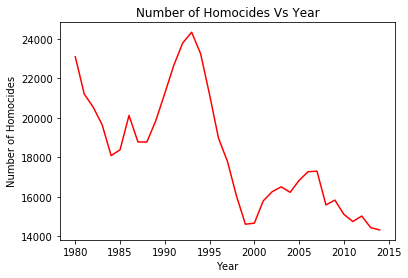

In [51]:
#Put data in plot, Year column is the x-axis, Count column is the y-axis
plt.plot(count_by_year['Year'], count_by_year['Count'], color='red')
#Label y axis
plt.ylabel('Number of Homocides')
#Label x axis
plt.xlabel('Year')
#Give the title of the plot
plt.title('Number of Homocides Vs Year')
#Show it
plt.show()

<p>The trend for the number of homocides seems to decrease by year in general. The number of homocides reached maximum in the period from 1990 to 1995 especially 1994 which has the largest number of homocides. After that, the number seems to be small and up to the most recent year in 2014, the number of homocides is the smallest.</p>
<h4>2.1.3 Statistic Data</h4>
<p>We would like to have some basic statistic for the number of homicides for all years in the period from 1980 to 2014.</p>

In [52]:
print("Each year the average of homicides is: " + str(count_by_year['Count'].mean()) + " homocides/year")
print("The standard deviation of number of homicides is: " + str(count_by_year['Count'].std()))

Each year the average of homicides is: 18241.5428571 homocides/year
The standard deviation of number of homicides is: 2986.44665253


<p>It can be said that the number of homocides is high in average which is 18241 cases per year. Also, the difference among the year is large as well which is showed by a quite large standard deviation.</p>
<h3>2.2 Homocides By Crime Type</h3>
<p>Next, we would like to see what the main reasons reported in these cases in order to see the general motives of perpetrators. This piece of information can help us be more aware of how these homicides happened.</p> 
<h4>2.2.1 Extract the Homocide Number Per Crime Type</h4>
<p>We use the same strategy as 2.1.1 but with Crime Type column.</p>

In [53]:
data_by_case = data.copy().groupby(data['Crime Type'], as_index=True, group_keys=True).count()
count_by_case = data_by_case[['Record ID']].reset_index()
count_by_case = count_by_case.rename(index=str, columns={'Record ID' : 'Count'})
count_by_case

,Crime Type,Count
0,Manslaughter by Negligence,9116
1,Murder or Manslaughter,629338


<p>When we look at the ratio between Manslaughter by Negligence and Murder or Manslaughler, the main reason for these homocides to happened is almost the same.</p>
<h3>2.3 Homocides By State</h3>
<p>It is interesting to know how many homocides happened in each state in the US. Now, we want to introduce how homocides distribute in the US with some cool visualization.</p> 
<h4>2.2.1 Extract the Homocide Number Per State</h4>
<p>We use the same strategy as 2.1.1 but with State column.</p>

In [54]:
data_by_state = data.copy().groupby(data['State'], as_index=True, group_keys=True).count()
count_by_state = data_by_state[['Record ID']].reset_index()
count_by_state = count_by_state.rename(index=str, columns={'Record ID' : 'Count'})
count_by_state.head()

,State,Count
0,Alabama,11376
1,Alaska,1617
2,Arizona,12871
3,Arkansas,6947
4,California,99783


<h4>2.2.2 Visualize Homocides Number With States With Graph</h4>
<p>We have successfully plotted the line graph of homocides number with year. Now, we do similar task but we will use horizontal bar plot in order to show the homocides number with states.</p>

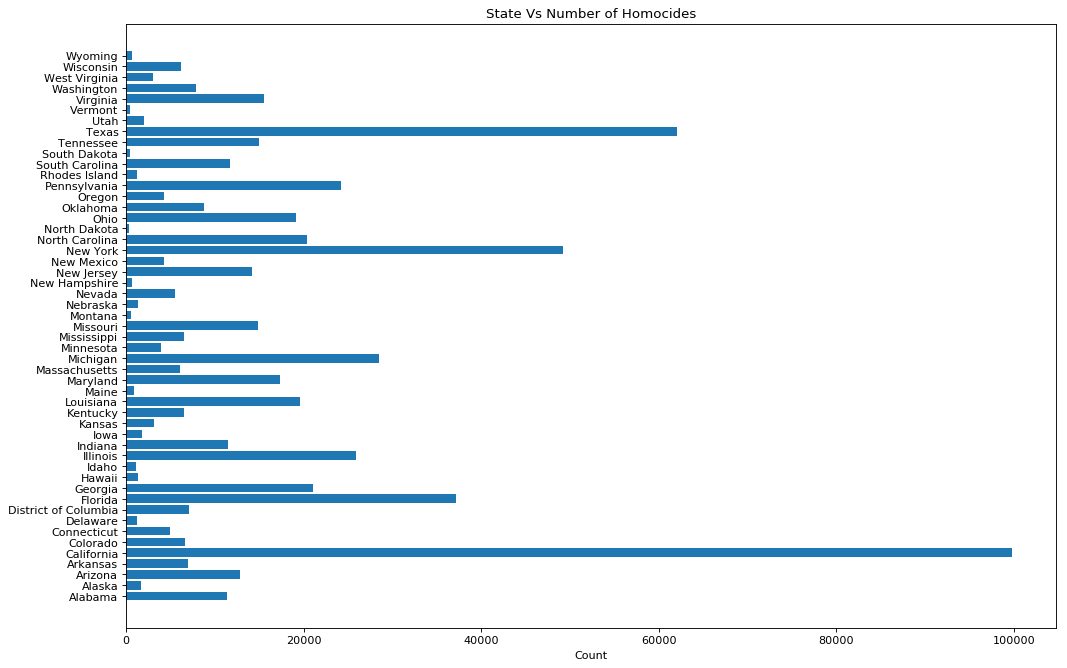

In [55]:
%matplotlib inline
#Initialize the size of the plot
plt.figure(figsize=(15, 10), dpi=80);
#Convert the State column to a numpy array
y_pos = np.arange(len(count_by_state['State']))
#Put the data into the plot
plt.barh(y_pos, count_by_state['Count'])
#Label y-axis
plt.yticks(y_pos, count_by_state['State'])
#Label x-axis
plt.xlabel('Count')
#Create title of the plot
plt.title('State Vs Number of Homocides')

<p>In the common intuition when we look at the graph, the number of homocides in each state seems to be proportional with the size and population of that state. In the graph, it shows that California has the largest number of homocides in this period. The runner-up is Texas and so on. Small number of homocides only happened in small states (in term of size and population) such as Montana, North Dakota, South Dakota, etc.</p>
<h4>2.2.3 Visualize Homocides Number With States With Map</h4>
<p>Here comes the cool part of this section. We would like to illustrate the number of homocides percentage by state on map. Python has a library called folium. In general, folium is a library that allows users to play with maps. More information about folium can be found at https://folium.readthedocs.io/en/latest/. In this section, we want to introduce folium's choropleth map in order to illustrate our data. In order to do this, we will need a file called us-states.json which is a geo json file contains the boundaries of the US States. The purpose of using this file lets us color the states based on the number of homocides. You can download the file by right clicking on the screen and select Save As at this URL: https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json. We will demonstrate how to make the map using the code below.</p>

In [56]:
#Import necessary libraries
import os
from branca.utilities import split_six
#Get the percentages of all states over the total of number of homocides
count_by_state['Percentage'] = count_by_state['Count']*100/count_by_state['Count'].sum()
#Some visualization optimization
threshold_scale = split_six(count_by_state['Percentage'])
#Make path for the json file
state_geo = os.path.join('us-states.json')

#Make the map with a start location and zoom size
m = folium.Map(location=[48, -102], zoom_start=3)

#Add choropleth layer in the map using the json file
#Import data from the count_by_state DataFrame with State and Percentage columns
#Set the keys on the state names
#Put in basic features such as color, opacities, legend_name, etc.
m.choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=count_by_state,
    columns=['State','Percentage'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of Homocides (%)',
    threshold_scale=threshold_scale,
    reset=True
)

folium.LayerControl().add_to(m)
m

<h3>2.4 Number of Perpetrators By Age</h3>
<p>The last analysis we would like to do is the number of perpetrators by age. The analysis plays an important role of determining the average age of perpetrator. This piece of information is useful for everyone to understand why perpetrators at a certain age acts as murderers.</p>
<h4>2.4.1 Extract the Homocides Number by Age</h4>
<p>We will use same strategy as 2.1.1 but we will use the perpetrator table.</p>

In [57]:
data_by_perp_age = ped_data.copy().groupby(ped_data['Perpetrator Age'], as_index=True, group_keys=True).count()
count_by_perp_age = data_by_perp_age[['Record ID']].reset_index()
count_by_perp_age = count_by_perp_age.rename(index=str, columns={'Record ID' : 'Count'})
count_by_perp_age.head()

,Perpetrator Age,Count
0,1,16
1,2,6
2,3,24
3,4,29
4,5,31


<h4>2.4.2 Visualize Homocides Number by Age</h4>
<p>We will visualize the data we retrieved above using the strategy in 2.3.2 but it will be better if we do vertical bar this time.</p>

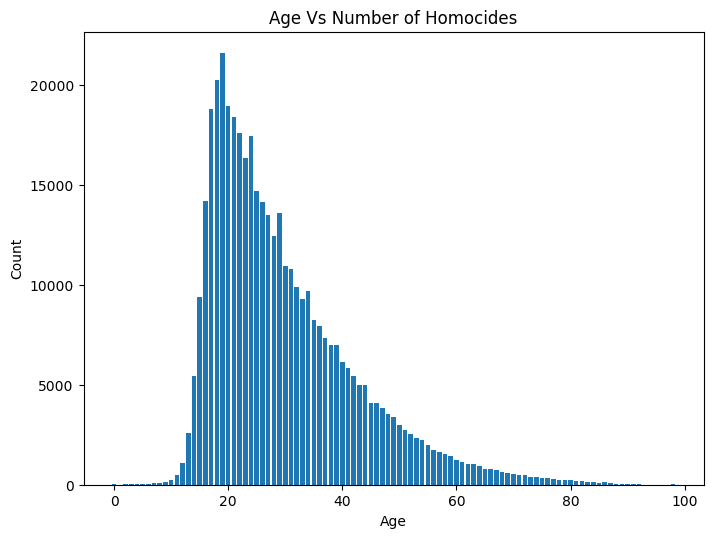

In [58]:
plt.figure(figsize=(8, 6), dpi=100);
y_pos = np.arange(len(count_by_perp_age['Perpetrator Age']))
plt.bar(y_pos, count_by_perp_age['Count'])
plt.ylabel('Count')
plt.xlabel('Age')
plt.title('Age Vs Number of Homocides')

In [59]:
print("The average age of a perpetrator is: " + str(sum(count_by_perp_age['Count']*count_by_perp_age['Perpetrator Age'])/ \
                                                    count_by_perp_age['Count'].sum()) + " years old")

The average age of a perpetrator is: 30.7294434743 years old


<p>The large number of perpetrators happened to be around 18 to 30. This comes to the fact that a perpetrator's average age is around 30. After 30, the number of perpetrators decreases as the age get larger. Also in the graph, the age that has most perpetrators is 19 which seems to be low for a perpetrator. It is noticeable that perpetrators does not appear much outside the working ages.</p>